## Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

from skimage.transform import rotate
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import load_model

# Metricas de resultados
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

## Functions

In [ ]:
main_path = "/content/drive/MyDrive/Univalle/Tesis/Tesis V1/"
dataset_path = main_path + "images/ds_segmented/"


def load_dataset(): #Carga las imagenes

  data = []
  targets = []
  print("Loading ",9*16," images...")
  
  for carpeta in range(9): # Carpeta por carpeta
    print("Loading folder "+str(carpeta))
    for i in range(16): # Imagen por imagen
      
      path_load = dataset_path + str(carpeta) + "/s" + str(carpeta) +"_" + str(i) + ".jpg"
      img = cv2.imread(path_load,0) # Cargar en B/N
      data.append(img)
			
      #print("Cargada imagen ", path_load)
      targets.append(carpeta)

  print("Completed")
  data = np.array(data)
  targets = np.array(targets)
  #print(data.shape)
  return data, targets

def img_augmented(img,targ,degrees_per_img=8,augmentation=3, shift = True):
  #print("Imgs per img: ",2*(degrees_per_img)*(augmentation+1))
  count = 0
  temp = []
  out_vector = []
  targets = []
  temp.append(img)
  flip_img = cv2.flip(img, 1)
  temp.append(flip_img)

  for img_i in np.array(temp):
    for degre in range(0,360,int(360/degrees_per_img)):
      rotated_img = rotate(img_i,degre,mode='edge')
      out_vector.append(rotated_img)
      targets.append(targ)

  
  # Distance, Light and shift variation
  temp = out_vector.copy()
  for img_i in temp: # image by image
    data = img_to_array(img_i)
    samples = np.expand_dims(data, 0)
    # Images generator
    datagen = ImageDataGenerator(#zoom_range=0.6, # Disable because width and height aren't proportional (distortion)
	    							brightness_range=[0.5,1.2],
	    							height_shift_range=[-3,3],
	    							width_shift_range=[-3,3],
                                    )
    it = datagen.flow(samples, batch_size=1)
    for i in range(augmentation):
      batch = it.next() # Output: tensor img [x,y,1]
      aug_img = batch[0].astype('uint8')
      aug_img = aug_img.reshape((aug_img.shape[0],aug_img.shape[1]))/255
      out_vector.append(aug_img)
      targets.append(targ)

      count+=1
    #count=0
  return out_vector, targets

def contraste(img,r_min=0,r_max=255): # Contrast adjustment 0 - 255
    img_c = img - np.min(img)
    img_c = (img_c/np.max(img_c))*r_max
    img_c = img_c.astype(np.uint8)
    return img_c

def ver_img(img): # View img
    img = contraste(img)
    cv2_imshow(img)

def train_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    plt.figure()
    plt.title("History")
    plt.subplot(121)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(hist["epoch"],hist["accuracy"],label="Train acc")
    plt.plot(hist["epoch"],hist["val_accuracy"],label="Val acc")
    plt.ylim([0.4,1.1])
    plt.legend()

    plt.subplot(122)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(hist["epoch"],hist["loss"],label="Loss")
    plt.plot(hist["epoch"],hist["val_loss"],label="Val loss")
    plt.ylim([0,1.5])
    plt.legend()

    plt.show()


## Load data and targets

In [ ]:
data_images, target = load_dataset()
#data_aug = db_augmented(data_images,degrees_per_img=8,augmentation=3)

Loading  144  images...
Loading folder 0
Loading folder 1
Loading folder 2
Loading folder 3
Loading folder 4
Loading folder 5
Loading folder 6
Loading folder 7
Loading folder 8
Completed


In [ ]:
targets = []
aug_data = []
for i in range(len(data_images)):
  aug_data_i,target_i = img_augmented(data_images[i],target[i])    
  aug_data.extend(aug_data_i)
  targets.extend(target_i)

aug_data = np.array(aug_data)
targets = np.array(targets)

In [ ]:
print(aug_data.shape)
print(targets.shape)

(9216, 112, 112)
(9216,)


## Prepare data

In [ ]:
# DATA_TRAIN Y DATA_TEST

Porcentaje_Data_Test= 0.4
x_train, x_test, y_train, y_test = train_test_split(aug_data, targets, test_size= Porcentaje_Data_Test,stratify=targets)

print("La cantidad de datos para entrenamiento es ",x_train.shape[0])
print("La cantidad de datos para test es ",x_test.shape[0])
print("El tamaño de las imagenes en pixeles es de ",x_test.shape[1:])
print("Datos de entrenamiento por clase son ",np.unique(y_train,return_counts=True)[1])

La cantidad de datos para entrenamiento es  5529
La cantidad de datos para test es  3687
El tamaño de las imagenes en pixeles es de  (112, 112)
Datos de entrenamiento por clase son  [614 615 614 614 615 614 614 614 615]


In [ ]:
# Se convierten los datos a Tensores 3D
data_test = x_test.reshape((x_test.shape[0],112,112,1))
data_train = x_train.reshape((x_train.shape[0],112,112,1))

# Se normalizan los datos para que queden en un rango de 0 a 1
data_test = data_test.astype('float32')
data_train = data_train.astype('float32')

y_train_hoc = to_categorical(y_train)
y_test_hoc = to_categorical(y_test)

## Data visualization

Algunos ejemplos aleatorios con sus respectivos Targets: 


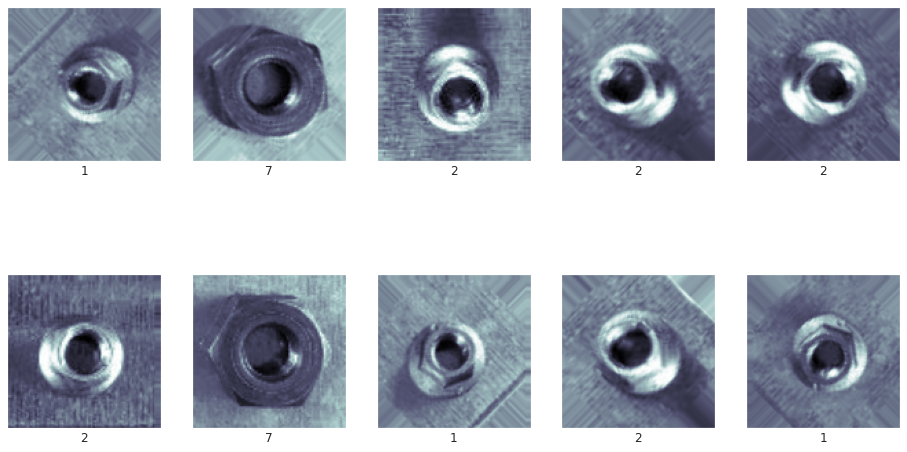

In [ ]:
print("Algunos ejemplos aleatorios con sus respectivos Targets: ")
fig, ax = plt.subplots(2,5,figsize=(16,9))
for i, ax_i in enumerate(ax.flat):
  n =i+np.random.randint(len(aug_data)-1)
  ax_i.imshow(aug_data[n],cmap="bone")
  ax_i.set(xticks=[],yticks=[],xlabel=targets[n])

## Model

In [ ]:
input_shape = (112,112,1)
optim =  'adam' #sgd
loss = 'categorical_crossentropy' # 'mse' 'categorical_crossentropy'
batch = 50
epochs = 10
dropout = 0.30

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = 'relu', input_shape = input_shape, padding= 'same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(32,(5,5),activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.15))

model.add(Flatten()) # Last step of extraction
"""
model.add(Dense(3136,activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(dropout))
"""
model.add(Dense(5408,activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(1352,activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(9,activation='softmax'))

model.compile(loss=loss, optimizer = optim, metrics = ['accuracy'])
history = model.fit(data_train,y_train_hoc,
          batch_size = batch,
          epochs = epochs,
          validation_data = (data_test,y_test_hoc))
print('\n')
test_loss , test_acc = model.evaluate(data_test,y_test_hoc)


Epoch 1/10
111/111 [==============================] - 6s 48ms/step - loss: 2.9003 - accuracy: 0.3517 - val_loss: 0.3985 - val_accuracy: 0.8695
Epoch 2/10
111/111 [==============================] - 5s 47ms/step - loss: 0.2913 - accuracy: 0.8905 - val_loss: 0.1862 - val_accuracy: 0.9346
Epoch 3/10
111/111 [==============================] - 5s 47ms/step - loss: 0.1353 - accuracy: 0.9482 - val_loss: 0.0761 - val_accuracy: 0.9756
Epoch 4/10
111/111 [==============================] - 5s 47ms/step - loss: 0.0904 - accuracy: 0.9690 - val_loss: 0.0845 - val_accuracy: 0.9694
Epoch 5/10
111/111 [==============================] - 5s 47ms/step - loss: 0.0521 - accuracy: 0.9822 - val_loss: 0.0743 - val_accuracy: 0.9731
Epoch 6/10
111/111 [==============================] - 5s 47ms/step - loss: 0.0541 - accuracy: 0.9809 - val_loss: 0.0950 - val_accuracy: 0.9677
Epoch 7/10
111/111 [==============================] - 5s 47ms/step - loss: 0.0619 - accuracy: 0.9804 - val_loss: 0.0519 - val_accuracy: 0.9843

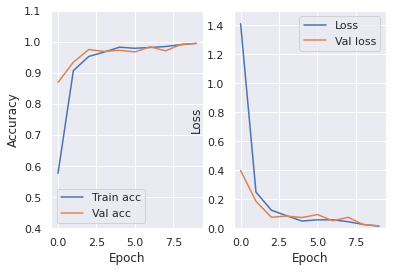

In [ ]:
train_history(history)

In [ ]:
model_name = 'Classifier_model_v6_.h5'
path_model = main_path+"models/"+model_name
model.save(path_model)
print('guardado modelo: ',model_name,' con un accuracy de ',test_acc,"\nEn ",path_model)

guardado modelo:  Classifier_model_v5_9984.h5  con un accuracy de  0.9983726739883423 
En  /content/drive/MyDrive/Univalle/Tesis/Tesis V1/models/Classifier_model_v5_9984.h5


# Results

Precisión en el Test:  0.9983726739883423
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       1.00      1.00      1.00       409
           2       1.00      1.00      1.00       410
           3       1.00      1.00      1.00       410
           4       1.00      1.00      1.00       409
           5       1.00      1.00      1.00       410
           6       1.00      1.00      1.00       410
           7       1.00      1.00      1.00       410
           8       1.00      1.00      1.00       409

    accuracy                           1.00      3687
   macro avg       1.00      1.00      1.00      3687
weighted avg       1.00      1.00      1.00      3687

Matriz de confusión


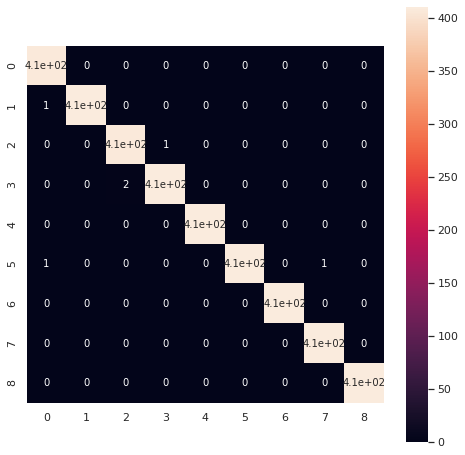

In [ ]:
prediction = model.predict(data_test)
pred = []

for i in range(prediction.shape[0]):
  pred.append(prediction[i].argmax())

print("Precisión en el Test: ",test_acc)
print(classification_report(y_test,pred))
print("Matriz de confusión")
mat = confusion_matrix(y_test,pred)
f, ax = plt.subplots(figsize=(8, 8))
ax= sns.heatmap(mat.T, square=True, annot=True, cbar=True)

plt.show()

# Prob analysis

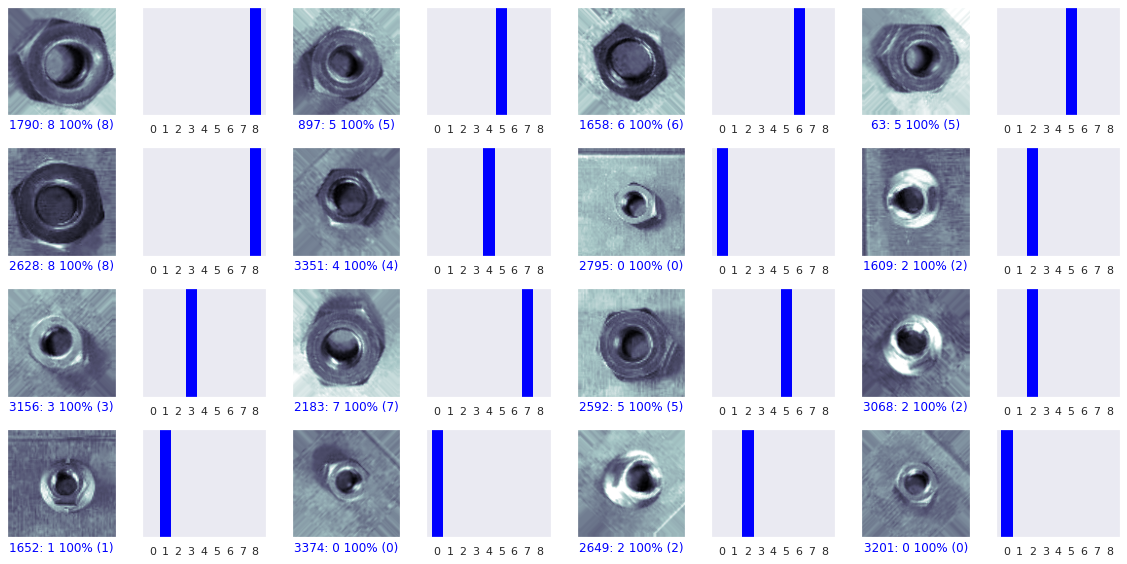

In [ ]:
class_names = ['0','1','2','3','4','5','6','7','8']

def plot_image(i, predictions_array, true_label, img,class_names = ['0','1','2','3','4','5','6','7','8']):
  predictions_array, true_label, img = predictions_array, true_label, img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap='bone')

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{}: {} {:2.0f}% ({})".format(i,class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label
  plt.grid(False)
  plt.xticks(range(9))
  plt.yticks([])
  thisplot = plt.bar(range(9), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  n= np.random.randint(0,x_test.shape[0])
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(n, prediction[n], y_test[n], x_test[n])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(n, prediction[n], y_test[n])
plt.tight_layout()
plt.show()